# Table of Contents
* [Data Exploration and Specification](#Data-Exploration-and-Specification)
	* [Data Specification](#Data-Specification)
	* [Variable screening](#Variable-screening)
		* [Date Variables](#Date-Variables)
		* [Categorical Variables](#Categorical-Variables)
		* [Continous variables](#Continous-variables)
		* [Missed values](#Missed-values)
		* [Sessions strucure](#Sessions-strucure)


# Data Exploration and Specification

<a id='section1'></a>

## Data Specification

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Read data from all provided data files.

In [23]:
users_path = 'data/train_users_2.csv'
countries_path = 'data/countries.csv'
age_genders_path = 'data/age_gender_bkts.csv'
sessions_path = 'data/sessions.csv'
test_users_path = 'data/test_users.csv'

In [24]:
users = pd.read_csv(users_path)
countries = pd.read_csv(countries_path)
age_genders = pd.read_csv(age_genders_path)
sessions = pd.read_csv(sessions_path)
test_users = pd.read_csv(test_users_path) 

In [25]:
import os
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0

In [26]:
print "Datasets details:"
width = 15
for f in ["users", "countries", "age_genders", "sessions", "test_users"]:
    size = convert_bytes(os.path.getsize(eval(f + "_path") ))
    print "{} | {} | {} columns | {} lines ".format(f.ljust(width), size.ljust(width), \
                                                   str(eval(f).shape[1]).ljust(3), \
                                                   str(eval(f).shape[0]).ljust(12))

Datasets details:
users           | 23.7 MB         | 16  columns | 213451       lines 
countries       | 632.0 bytes     | 7   columns | 10           lines 
age_genders     | 11.6 KB         | 5   columns | 420          lines 
sessions        | 602.4 MB        | 6   columns | 10567737     lines 
test_users      | 6.4 MB          | 15  columns | 62096        lines 


We will briefly look at these datasets to understand what kind of variables we will have for analysis. 

In [27]:
df_users = users.describe(include='all').transpose()[['count', 'unique', 'top']]
df_all_users = df_users.join(test_users.describe(include='all').transpose()[['count', 'unique', 'top']],
                             lsuffix=" (train)", rsuffix=" (test)")
df_all_users["perc missed (train)"] = (1 - df_all_users["count (train)"]/users.shape[0]) * 100
df_all_users["perc missed (test)"] = (1 - df_all_users["count (test)"]/test_users.shape[0]) * 100
df_all_users

,count (train),unique (train),top (train),count (test),unique (test),top (test),perc missed (train),perc missed (test)
id,213451,213451,wm38s2q7pp,62096,62096,p5xo3bxz4w,0,0
date_account_created,213451,1634,2014-05-13,62096,92,2014-07-23,0,0
timestamp_first_active,213451,NaN,NaN,62096,NaN,NaN,0,0
date_first_booking,88908,1976,2014-05-22,0,NaN,NaN,58.3473,100
gender,213451,4,-unknown-,62096,4,-unknown-,0,0
age,125461,NaN,NaN,33220,NaN,NaN,41.2226,46.5022
signup_method,213451,3,basic,62096,4,basic,0,0
signup_flow,213451,NaN,NaN,62096,NaN,NaN,0,0
language,213451,25,en,62096,24,en,0,0
affiliate_channel,213451,8,direct,62096,7,direct,0,0


<p>As expected test_users dataset contains the same fields as users except for target variable country_destination. For detailed information about variables meaning see Data Specification document.
<br>Since date_first_booking variable is directly connected to the fact of booking, it is not presented in the test dataset. As was stated by data provider, this variable appeared in the train dataset by accident and should not be considered.</p>

The following variables will be used for further analysis:
* *Date variables*
    * date_account_created
    * timestamp_first_active (will be transformed to date later) 
* *Categorical variables*
    * gender
    * signup_method
    * signup_flow
    * language
    * affiliate_channel
    * affiliate_provider
    * first_affiliate_tracked
    * signup_app
    * first_device_type
    * first_browser
* *Continuous variables*
    * age
* *Target variable (Categorical)* 
    * country_destination
    
We alredy can notice that some categorical variables have high number of level, e.g. first_browser (52 levels in training dataset), language(25 levels). This variables can be difficult for analysis (especialy if levels are also unbalanced).
<br>
Percent of missing values for age is 41% in train dataset and 46% in test dataset. Nearly half values for this variables are missing!
For variable first_affiliate_tracked nearly 2.8% of values are missing in train dataset and only 0.03% in test dataset. 

In [28]:
sessions_desc = sessions.describe(include='all').transpose()[['count', 'unique', 'top']]
sessions_desc["perc missing"] = (1 - sessions_desc["count"]/sessions.shape[0]) * 100
sessions_desc

,count,unique,top,perc missing
user_id,10533241,135483,mxqbh3ykxl,0.326428
action,10488111,359,show,0.753482
action_type,9441533,10,view,10.657
action_detail,9441533,155,view_search_results,10.657
device_type,10567737,14,Mac Desktop,0
secs_elapsed,1.04317e+07,NaN,NaN,1.28723


Session dataset provides information about web sessions for users from users and test_users datasets
In sessions dataset there are 6 fields, user_id field can be used for joining with users and test_users data set.

From preceding table we can see that session information is provided for 135483 users, in average for each user there are 78 actions. 

The following variables will be used for further analysis:
* *Categorical variables*
    * action
    * action_type
    * action_detail
    * device_type
* *Continuous variables*
    * secs_elapsed
    
In this dataset there are categorical variables with quite large number of levels: action (359 levels), action_detail (155 levels)
Variable user_id is a foreign key used to join sessions with users dataset, but this variable also has some missing values - 0.3%.
Such action specifications as action_type and action_detail have nearly 10% missing values, but variable action itself has only 0.7% missing values.
    

In [29]:
age_genders.describe(include='all')[:3]

,age_bucket,country_destination,gender,population_in_thousands,year
count,420,420,420,420.0,420.0
unique,21,10,2,NaN,NaN
top,85-89,US,male,NaN,NaN


In [30]:
countries.head(4)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25


Remainig datasets are age_genders and countries. These datasets do not provide information directly about users, so presented variables can not be used as predictors. However they can be involved somehow in analysis, countries dataset provides some additional information about target variable 



## Variable screening 

<a id='section3'></a>
The target value is *destination country*, according to specification there are 
12 possible variants: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'.

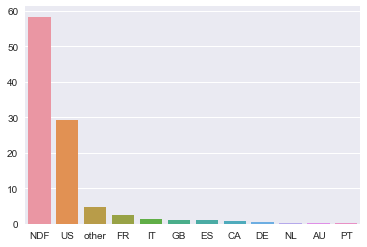

In [31]:
counts_dest = users.country_destination.value_counts(dropna=False)
perc_dest = 100 * counts_dest/users.shape[0]
sns.barplot(perc_dest.index, perc_dest.values)

Number of cases and percent in each target class

In [32]:
pd.DataFrame({"# cases" : counts_dest.apply(lambda v : "%d" % v), "% cases" : perc_dest}).transpose()

,NDF,US,other,FR,IT,GB,ES,CA,DE,NL,AU,PT
# cases,124543,62376,10094,5023,2835,2324,2249,1428,1061,762,539,217
% cases,58.3473,29.2226,4.72895,2.35323,1.32817,1.08877,1.05364,0.669006,0.49707,0.356991,0.252517,0.101663


Target variable country_destination is quite unbalanced. Most cases (nearly 60%) correspons to 'NDF' - situation when booking was not made. The second destination is 'US' - nearly 30 % of all trainig cases. This means that only 10% of cases corresponds to other destinations, where 5% relates to not listed destination ('other' group). 

### Date Variables

Now we will consider date variables.
<br> First convert variables to datetime type, transform timestamp_first_active to date_first_active

In [33]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')
users[["date_account_created", "date_first_booking", "date_first_active"]].describe()

,date_account_created,date_first_booking,date_first_active
count,213451,88908,213451
unique,1634,1976,1639
top,2014-05-13 00:00:00,2014-05-22 00:00:00,2014-05-13 00:00:00
freq,674,248,673
first,2010-01-01 00:00:00,2010-01-02 00:00:00,2009-03-19 00:00:00
last,2014-06-30 00:00:00,2015-06-29 00:00:00,2014-06-30 00:00:00


date_first_active can be before date_account_created 

In [34]:
signup_delay = users["date_account_created"] - users["date_first_active"]
signup_delay = signup_delay.apply(lambda d: d/np.timedelta64(1,'D')) 
print "Number and percent of cases for positive signup_delay: %d, %.3f%% " % \
                  (((signup_delay>0).sum()), (100 * float((signup_delay>0).sum())/users.shape[0]) )

Number and percent of cases for positive signup_delay: 178, 0.083% 


In [35]:
test_users['date_account_created'] = pd.to_datetime(test_users['date_account_created'])
test_users['date_first_active'] = pd.to_datetime((test_users.timestamp_first_active // 1000000), format='%Y%m%d')
test_users[["date_account_created", "date_first_active"]].describe()

,date_account_created,date_first_active
count,62096,62096
unique,92,92
top,2014-07-23 00:00:00,2014-07-23 00:00:00
freq,1105,1105
first,2014-07-01 00:00:00,2014-07-01 00:00:00
last,2014-09-30 00:00:00,2014-09-30 00:00:00


In [36]:
signup_delay_test = test_users["date_account_created"] - test_users["date_first_active"]
signup_delay_test = signup_delay_test.apply(lambda d: d/np.timedelta64(1,'D')) 
print "Number and percent of cases for positive signup_delay (test_users): %d, %.3f%% " % \
                  (((signup_delay_test>0).sum()), (100 * float((signup_delay_test>0).sum())/test_users.shape[0]) )

Number and percent of cases for positive signup_delay (test_users): 0, 0.000% 


There are a few cases in train_users where variables date_account_created and date_first_active are different, there are no such cases in test_users

### Categorical Variables

Here we will consider categorical variables.
First check values of variables from users dataset

In [37]:
def plot_categories(df, variable):
    perc = 100 * df[variable].value_counts(normalize=True, dropna=False)
    plt.figure()
    if len(perc) <= 5: 
        plt.xlabel(variable)
        plt.ylabel("Cases, %")
        x = perc.index
        y = perc.values
    else:
        plt.xlabel("Cases, %")
        plt.ylabel(variable)
        y = perc.index
        x = perc.values
    print sns.barplot(x, y) 

def print_var_levels(df, cols, excl_col = []):
    for col in cols:
        if col in excl_col:
            continue
        print "\n" , col
        print "******************************************"
        print df[col].unique()
        
def perc_counts(data_col, dropna = False):
    counts = data_col.value_counts(dropna = False)
    perc = 100 * data_col.value_counts(normalize=True, dropna = dropna)
    return pd.concat([counts, perc], join='inner', axis=1, keys = ["number", "perc"])
        
def nrm_entropy(v):
    n = len(v)
    s = 0
    for val in v:
        if val > 0:
            s += - val/100. * np.log2(val/100.)
    return s/np.log2(n)
     
    
def var_values(df, excl_col = []):
    res = pd.DataFrame([], columns=["field", "# levels", "max % cases in a level", \
                                    "min % cases in a level", "min # cases in a level", \
                                   "nrm_entropy"])
    for col in df.columns:
        if col in excl_col:
            continue
        s = df[col]
        counts_dest = df[col].value_counts(dropna=False)
        perc_dest = 100 * counts_dest/df.shape[0]
        vc = pd.DataFrame({"number" : counts_dest, "perc" : perc_dest})
        
        res = res.append(pd.DataFrame([[col, len(vc), vc.perc.max(), vc.perc.min(), \
                                        vc.perc.median(), vc.number.min(), nrm_entropy(vc.perc.values)]], 
                        columns=["field", "# levels", "max % cases in a level", "min % cases in a level", \
                                 "median % cases in a level", "min # cases in a level", "nrm_entropy"]),
                     ignore_index=True)
    return res[["field", "# levels", "max % cases in a level", "min % cases in a level", \
                                 "median % cases in a level", "min # cases in a level", "nrm_entropy"]]
    

In [38]:
excl_vars = ["id","age", "date_account_created", "date_first_active", \
             "timestamp_first_active", "date_first_booking", "country_destination"]
var_values(users, excl_vars)

,field,# levels,max % cases in a level,min % cases in a level,median % cases in a level,min # cases in a level,nrm_entropy
0,gender,4.0,44.829024,0.132115,27.519431,282.0,0.776968
1,signup_method,3.0,71.630960,0.255796,28.113244,546.0,0.556153
2,signup_flow,17.0,77.178837,0.000468,0.141016,1.0,0.336070
3,language,25.0,96.656375,0.000937,0.029983,2.0,0.069690
4,affiliate_channel,8.0,64.523942,0.513467,4.128348,1096.0,0.597537
5,affiliate_provider,18.0,64.382926,0.000468,0.243850,1.0,0.367700
6,first_affiliate_tracked,8.0,51.174274,0.015929,2.862718,34.0,0.598851
7,signup_app,4.0,85.601379,2.555153,5.921734,5454.0,0.393672
8,first_device_type,9.0,41.976847,0.035605,4.997400,76.0,0.641154
9,first_browser,52.0,29.910846,0.000468,0.004685,1.0,0.450814


From the table above we can see number of levels for each categorical variable and estimate of cases distribution among levels. Some variables like language are highly unbalanced meaning that most cases correspond only to the few levels.

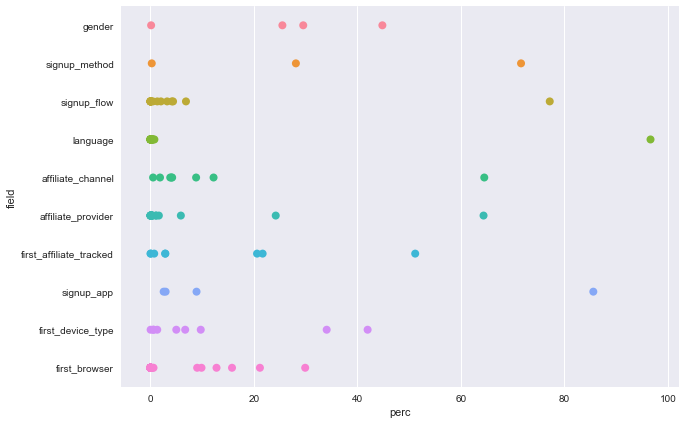

In [39]:
def get_levels_stat(df, excl_fields=None):
    res = pd.DataFrame([], columns=["field", "level", "count", "perc"])
    for field in df.columns:
        if field in excl_fields:
            continue
        counts = df[field].value_counts(dropna=False)
        perc = 100 * counts/df.shape[0]
        levels_stat = pd.DataFrame({ "field": field, "level" : perc.index, "perc" : perc, "count": counts })
        res = res.append(levels_stat, ignore_index=True)
    return res

excl_vars = ["id","age", "date_account_created", "date_first_active", \
             "timestamp_first_active", "date_first_booking", "country_destination"]

fields_stat = get_levels_stat(users, excl_vars)

fig, ax = plt.subplots(figsize=(10,7))
sns.stripplot(y="field", x="perc", data=fields_stat, size=8, ax=ax)

In [40]:
fields_gr = fields_stat.groupby("field")["perc"].agg(["min", "median", "max"])
fields_gr["Min_Max Difference"] = fields_gr["max"]-fields_gr["min"]
fields_gr.sort(columns=["Min_Max Difference"], ascending=False, inplace=True)
fields_gr

/anaconda/envs/xgb_last/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,min,median,max,Min_Max Difference
field,,,,
language,0.000937,0.029983,96.656375,96.655438
signup_app,2.555153,5.921734,85.601379,83.046226
signup_flow,0.000468,0.141016,77.178837,77.178369
signup_method,0.255796,28.113244,71.630960,71.375163
affiliate_provider,0.000468,0.243850,64.382926,64.382458
affiliate_channel,0.513467,4.128348,64.523942,64.010475
first_affiliate_tracked,0.015929,2.862718,51.174274,51.158345
gender,0.132115,27.519431,44.829024,44.696909
first_device_type,0.035605,4.997400,41.976847,41.941242


Almost all categorical variables have levels with very low number of observations
<br>Some variable levels like '-unknown-', "untracked", etc are possible missing valies, because they do not give any specific information.


Next consider session variables

In [42]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [43]:
var_values(sessions, ["user_id", "secs_elapsed"])

,field,# levels,max % cases in a level,min % cases in a level,median % cases in a level,min # cases in a level,nrm_entropy
0,action,360.0,26.195561,0.000009,0.004471,1.0,0.548525
1,action_type,11.0,33.695975,0.000038,5.898680,4.0,0.708341
2,action_detail,156.0,16.814243,0.000009,0.025862,1.0,0.603230
3,device_type,14.0,34.011880,0.000643,1.661496,68.0,0.636909


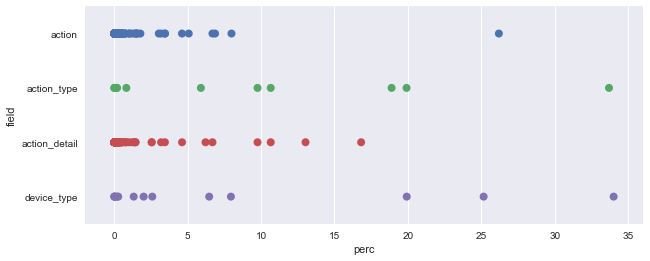

In [44]:
ses_fields_stat = get_levels_stat(sessions, ["user_id", "secs_elapsed"])

fig, ax = plt.subplots(figsize=(10,4))
sns.stripplot(y="field", x="perc", data=ses_fields_stat, size=8, ax=ax)

### Continous variables

In [46]:
pd.concat ([users['age'].describe(), test_users['age'].describe()], axis=1, keys = ['age(train)', 'age(test)'])

,age(train),age(test)
count,125461.000000,33220.000000
mean,49.668335,37.616677
std,155.666612,74.440647
min,1.000000,1.000000
25%,28.000000,26.000000
50%,34.000000,31.000000
75%,43.000000,40.000000
max,2014.000000,2002.000000


Age variable has a lot of missing values (nearly 41% in training set and 46% in test data set).
Age variable also has some outliers in both datasets. Minumun value is 1 and max value is greater that 2000.

In [47]:
users['source']="Train"
test_users['source']="Test"
all_users = pd.concat([users, test_users], axis=0).reindex()

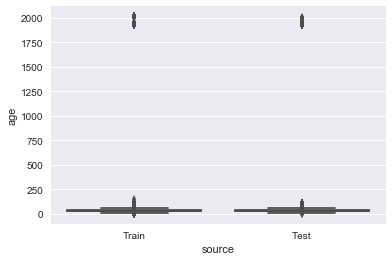

In [48]:
sns.boxplot("source", 'age', data=all_users)

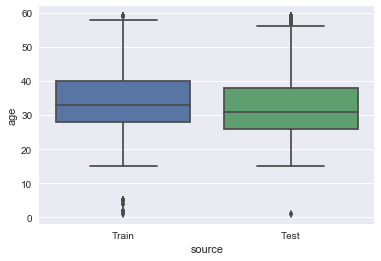

In [60]:
sns.boxplot("source", 'age', data=all_users[all_users['age']<60])

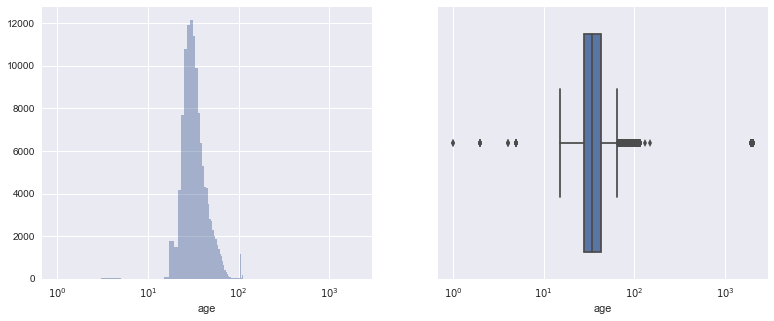

In [77]:
keep = (users.age.notnull()) 
fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
sns.distplot(users[keep].age, ax=ax[0], bins=1000, kde=False, color= sns.xkcd_rgb["denim blue"])
sns.boxplot('age', data=users[keep], ax=ax[1])

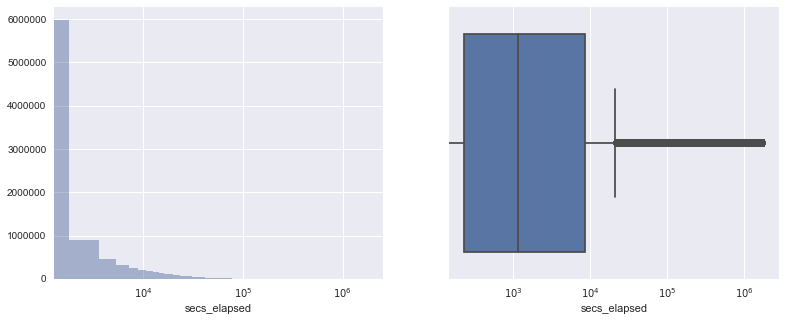

In [79]:
keep = (sessions.secs_elapsed.notnull()) 
fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
sns.distplot(sessions[keep].secs_elapsed, ax=ax[0], bins=1000, kde=False, color= sns.xkcd_rgb["denim blue"])
sns.boxplot('secs_elapsed', data=sessions[keep], ax=ax[1])

### Missed values

In [45]:
not_specified_levels = ["-unknown-", "untracked", "other/unknown", "unknown", "nan"]
print "Missing values in users data set\n" + "*"*40
print fields_stat[fields_stat.level.str.lower().isin(not_specified_levels) | fields_stat.level.isnull()] \
                .groupby("field").perc.sum()
print "\nMissing values in sessions data set\n" + "*"*40
print ses_fields_stat[ses_fields_stat.level.str.lower().isin(not_specified_levels) | ses_fields_stat.level.isnull()] \
                .groupby("field").perc.sum()

Missing values in users data set
****************************************
field
first_affiliate_tracked    54.015676
first_browser              12.773892
first_device_type           4.997400
gender                     44.829024
Name: perc, dtype: float64

Missing values in sessions data set
****************************************
field
action            0.753482
action_detail    20.414446
action_type      20.414721
device_type       1.999283
Name: perc, dtype: float64


Gender is unknown for nearly half users - 45%, first_affiliate_tracked is untracked for 51% of users.

Action is specified for most records, action_detail and action_type is missed for nearly 20% cases.

### Sessions strucure

In [46]:
100 * sessions.action_type.value_counts(normalize=True, dropna=False)

view                33.695975
data                19.907479
click               18.889408
NaN                 10.657003
-unknown-            9.757718
submit               5.898680
message_post         0.824235
partner_callback     0.181042
booking_request      0.177644
modify               0.010778
booking_response     0.000038
Name: action_type, dtype: float64

In [109]:
100 * sessions[sessions.action_type=="submit"].action.value_counts(normalize=True)

update                       56.541597
create                       16.967324
ask_question                  7.068662
authenticate                  6.156665
notifications                 5.251405
apply_reservation             1.751003
connect                       1.622024
requested                     1.422459
qt_reply_v2                   1.368076
set_user                      1.124877
delete                        0.219457
add_note                      0.154165
set_password                  0.121279
cancel                        0.093526
email_share                   0.051175
forgot_password               0.036255
change_password               0.027593
ajax_worth                    0.008984
change_availability           0.006738
set_default                   0.003048
respond                       0.001765
destroy                       0.000963
approve                       0.000642
refund_guest_cancellation     0.000321
dtype: float64

In [116]:
sessions[sessions.action == "personalize"].action_type.value_counts(normalize=True)

data    1
dtype: float64

In [117]:
sessions[(sessions.action == "personalize")&(sessions.action_type =="data") ].action_detail.value_counts(normalize=True)

wishlist_content_update    1
dtype: float64

<a id='section6'></a>